# First LSTM Model
Author: Camilla Billari <br> 
Date: 19/01/24

Fitting my first LSTM to the Marone p4581 experiment.

In [2]:
# Import relevant libraries
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import tqdm

# Change local path
MAIN_DICT = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability"
sys.path.append(MAIN_DICT)

# Import local modules - note: dependent on above path being set.
from utils.dataset import SlowEarthquakeDataset

## Load Data

In [3]:
# Directories paths
GTC_DATA_DIR = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/data/gtc_quakes_data"
LABQUAKES_DATA_DIR = f"{GTC_DATA_DIR}/labquakes"
DATA_DIR = f"{LABQUAKES_DATA_DIR}/Marone"
EXP = "p4581"

# Open experiment in a dataframe
EXP_FILE_PATH = f"{DATA_DIR}/{EXP}/{EXP}.txt"

In [4]:
# Access experiment and output dataframe head using Pritt's data loaders (which utilises Adriano's loading + pre-processing)
dataset = SlowEarthquakeDataset([EXP])
dataset.load()

# Get data optupts
ds_exp = dataset[EXP]
X, Y, t = ds_exp["X"], ds_exp["Y"], ds_exp["t"]

# Create dataframe
df = pd.DataFrame(
    np.hstack((X, Y, t.reshape(-1, 1))),
    columns=[ds_exp["hdrs"]["X"], *ds_exp["hdrs"]["Y"], ds_exp["hdrs"]["t"]],
)

print("N samples: {}".format(len(df)))
df.head()

N samples: 200010


,det_shear_stress,obs_shear_stress,obs_normal_stress,obs_ecdisp,obs_shear_strain,time
0,0.002811,1.29911,2.99288,NaN,NaN,0.000
1,0.002731,1.29903,2.99008,NaN,NaN,0.001
2,0.002231,1.29853,2.98854,NaN,NaN,0.002
3,0.002411,1.29871,2.98849,NaN,NaN,0.003
4,0.002241,1.29854,2.99069,NaN,NaN,0.004


### Creating the datastet

In [7]:
# Train-test split for time series
timeseries = np.array(df["det_shear_stress"])

train_size = int(len(timeseries) * 0.80)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [8]:
def create_dataset(dataset, lookback, forecast):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset) - lookback - forecast):
        feature = dataset[i : i + lookback]
        target = dataset[i + lookback : i + lookback + forecast]
        X.append(feature)
        y.append(target)
    return torch.from_numpy(np.array(X, dtype=np.float32)), torch.from_numpy(
        np.array(y, dtype=np.float32)
    )

In [9]:
lookback, forecast = 10, 1
X_train, y_train = create_dataset(train, lookback, forecast)
X_test, y_test = create_dataset(test, lookback, forecast)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([159997, 10]) torch.Size([159997, 1])
torch.Size([39991, 10]) torch.Size([39991, 1])


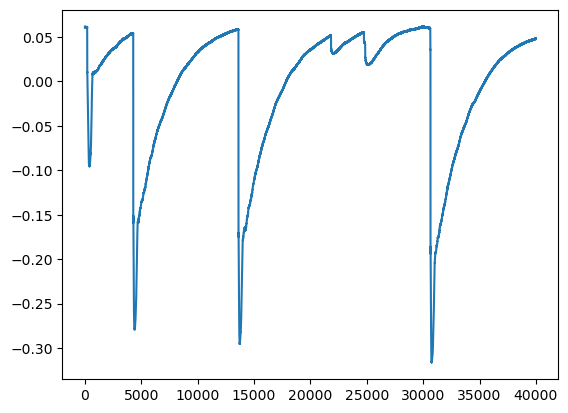

In [10]:
plt.plot(X_test[:, 2])

## Modelling

In [11]:
import torch.nn as nn


class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=forecast, hidden_size=50, num_layers=1, batch_first=True
        )
        self.linear = nn.Linear(50, forecast)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

### Training

In [ ]:
# Check CUDA Availability
if torch.cuda.is_available():
    dev = "cuda"
    map_location = None
    print(f"Total number of GPUs available: {torch.cuda.device_count()}")
    !nvidia-smi
else:
    dev = "cpu"
    map_location = "cpu"
    print("No GPU available.")
device = torch.device(dev)

In [ ]:
import torch.optim as optim
import torch.utils.data as data

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(
    data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8
)

n_epochs = 200
pbar = tqdm.tqdm(range(n_epochs))

for epoch in pbar:
    model.train()

    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    if epoch % 100 != 0:
        continue

    model.eval()

    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))

    print(
        "Epoch %d: train RMSE %.4f, test RMSE %.4f"
        % (epoch, train_rmse, test_rmse)
    )

## Results

In [ ]:
with torch.no_grad():
    # Shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # Shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size + lookback : len(timeseries)] = model(X_test)[
        :, -1, :
    ]
# plot
plt.plot(timeseries, c="b")
plt.plot(train_plot, c="r")
plt.plot(test_plot, c="g")
plt.show()